In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [3]:
train_dir = "chest_xray/train"
training_generator = ImageDataGenerator(rescale=1/255)
data_train = training_generator.flow_from_directory(train_dir)

Found 5216 images belonging to 2 classes.


In [4]:
test_dir = "chest_xray/test"
testing_generator = ImageDataGenerator(rescale=1/255)
data_test = testing_generator.flow_from_directory(test_dir)

Found 624 images belonging to 2 classes.


In [5]:
val_dir = "chest_xray/val"
valid_generator = ImageDataGenerator(rescale=1/255)
data_test = valid_generator.flow_from_directory(val_dir)

Found 16 images belonging to 2 classes.


In [6]:
train_dir = "chest_xray/train"
test_dir  = "chest_xray/test"
val_dir   = "chest_xray/val"

def count_images(directory):
    num_pneumonia = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    num_normal = len(os.listdir(os.path.join(directory, 'NORMAL')))
    return num_pneumonia, num_normal

def print_set_info(set_name, num_pneumonia, num_normal):
    print(f"{set_name} set:\n========================================")
    print(f"PNEUMONIA={num_pneumonia}")
    print(f"NORMAL={num_normal}")
    print()

train_pneumonia, train_normal = count_images(train_dir)
test_pneumonia, test_normal   = count_images(test_dir)
val_pneumonia, val_normal     = count_images(val_dir)

print_set_info("Train", train_pneumonia, train_normal)
print_set_info("Test", test_pneumonia, test_normal)
print_set_info("Validation", val_pneumonia, val_normal)

Train set:
PNEUMONIA=3875
NORMAL=1341

Test set:
PNEUMONIA=390
NORMAL=234

Validation set:
PNEUMONIA=8
NORMAL=8



In [7]:
import plotly.graph_objects as go
fig = go.Figure()

# Training data set
fig.add_trace(go.Bar(
    x=["pneumonia", "normal"],
    y=[len(os.listdir(train_dir + "/PNEUMONIA")), len(os.listdir(train_dir + "/NORMAL"))],
    marker=dict(color=['orange', 'orange']),
    name="Training data set"
))
# Test data set
fig.add_trace(go.Bar(
    x=["pneumonia", "normal"],
    y=[len(os.listdir(test_dir + "/PNEUMONIA")), len(os.listdir(test_dir + "/NORMAL"))],
    marker=dict(color=['green', 'green']),
    name="Test data set"
))

fig.update_layout(
    title="Data Set Distribution",
    xaxis=dict(title="Categories"),
    yaxis=dict(title="Count"),
    barmode="overlay"
)
fig.show()

In [8]:
import glob

In [9]:
ROOT_DIR = "chest_xray"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for Images in sets:
    path = os.path.join(ROOT_DIR, Images)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)
print("〰"*20)
print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Total Pneumonia Images: 4273
Total Normal Images: 1583
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


In [10]:
import plotly.graph_objects as go
from plotly.offline import iplot

labels = ["Normal", "Pneumonia"]
values = [len(all_normal), len(all_pneumonia)]
colors = ['sky blue', 'pink']

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.5)])
fig.update_traces(
    hoverinfo='value', 
    textinfo='label+percent', 
    textfont_size=20,
    marker=dict(colors=colors, line=dict(color='#000000', width=3))
)
fig.update_layout(
    title="Image Category Distribution",
    title_font={'size': 30}
)
iplot(fig)

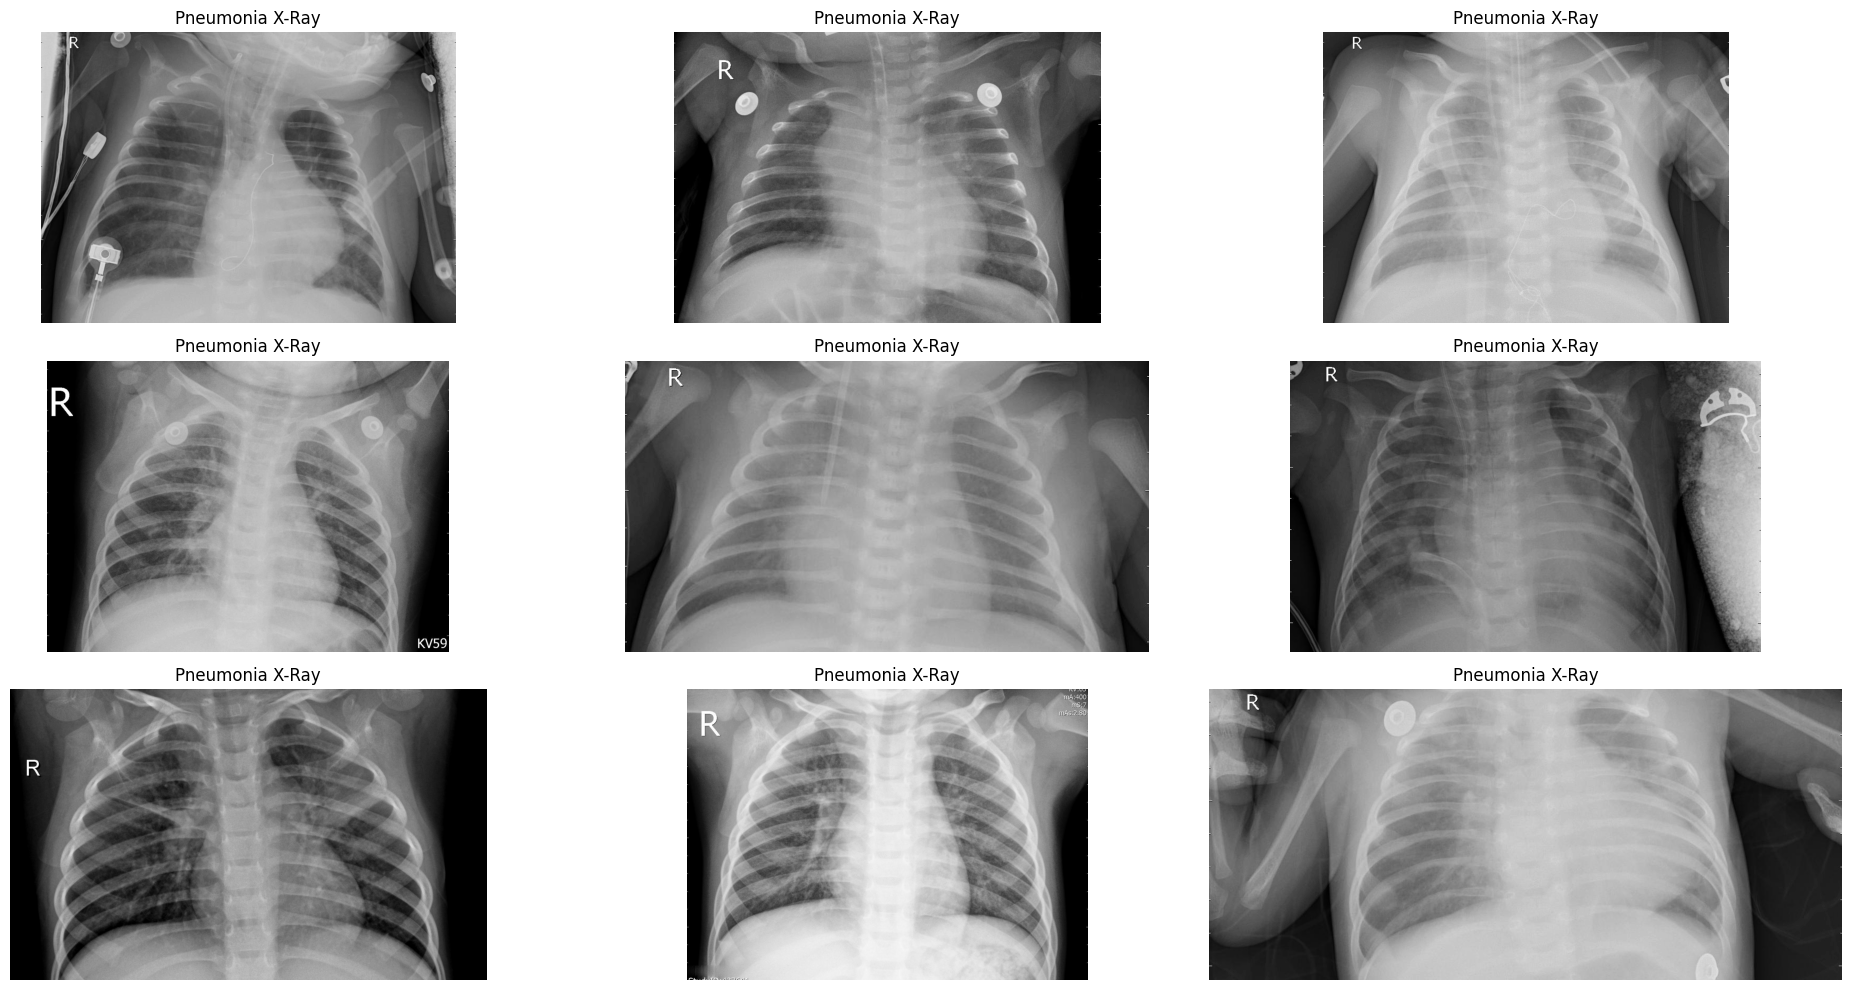

In [11]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray") 
plt.tight_layout()

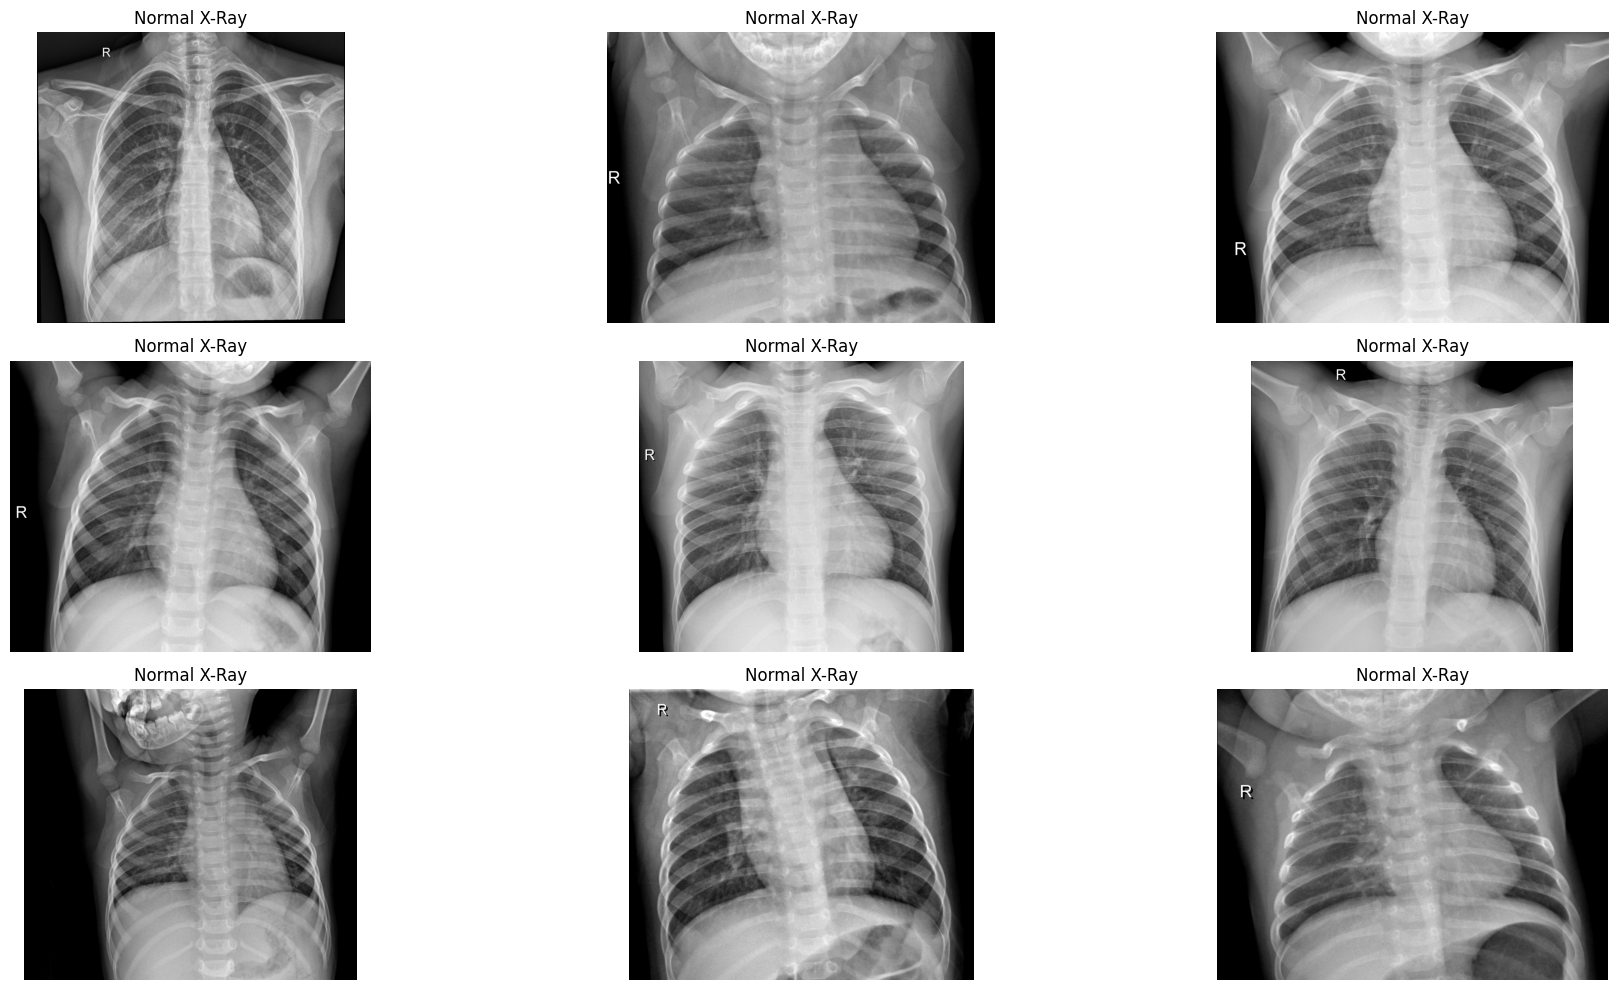

In [12]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray") 
   
plt.tight_layout()

In [13]:
def count_images(directory):
    num_pneumonia = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    num_normal = len(os.listdir(os.path.join(directory, 'NORMAL')))
    return num_pneumonia, num_normal

def plot_bar_graph(set_name, num_pneumonia, num_normal):
    labels = ['Pneumonia', 'Normal']
    values = [num_pneumonia, num_normal]
    colors = ['skyblue', 'pink']

    fig = go.Figure(data=[go.Bar(x=labels, y=values, marker=dict(color=colors))])
    fig.update_traces(
        text=values,
        textposition='auto',
    )
    fig.update_layout(
        title=f"Image Category Distribution - {set_name} Set",
        xaxis_title="Category",
        yaxis_title="Count",
        title_font={'size': 30}
    )
    iplot(fig)

train_dir = "chest_xray/train"
train_pneumonia, train_normal = count_images(train_dir)
plot_bar_graph("Train", train_pneumonia, train_normal)


    Here as we can see the data seems imbalanced,So to increase the no. of training examples,we will use data augmentation

The below code prepares image data by loading, resizing, and converting images to grayscale. It creates a NumPy array containing the resized images and their corresponding class labels.

In [14]:
import cv2

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [15]:
train = get_training_data('chest_xray/train')
test = get_training_data('chest_xray/test')
val = get_training_data('chest_xray/val')

/var/folders/g8/40cfrzs132l1krcw1vkvjhcw0000gn/T/ipykernel_97695/2852144342.py:17: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [16]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

x_train, y_train = zip(*train)
x_test, y_test = zip(*test)
x_val, y_val = zip(*val)


In [17]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

    Data Augmentation

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip = True,
        vertical_flip=False) 


datagen.fit(x_train)

In [19]:
Bio_model = Sequential()
Bio_model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
Bio_model.add(BatchNormalization())
Bio_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
Bio_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
Bio_model.add(Dropout(0.1))
Bio_model.add(BatchNormalization())
Bio_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
Bio_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
Bio_model.add(BatchNormalization())
Bio_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
Bio_model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
Bio_model.add(Dropout(0.2))
Bio_model.add(BatchNormalization())
Bio_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
Bio_model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
Bio_model.add(Dropout(0.2))
Bio_model.add(BatchNormalization())
Bio_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
Bio_model.add(Flatten())
Bio_model.add(Dense(units = 128 , activation = 'relu'))
Bio_model.add(Dropout(0.2))
Bio_model.add(Dense(units = 1 , activation = 'sigmoid'))
Bio_model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
Bio_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [21]:
history = Bio_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=12,
    validation_data=datagen.flow(x_val, y_val),
    callbacks=[learning_rate_reduction]
)

Epoch 1/12
163/163 [==============================] - 115s 696ms/step - loss: 0.4805 - accuracy: 0.8399 - val_loss: 8.0235 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 125s 767ms/step - loss: 0.2774 - accuracy: 0.8923 - val_loss: 65.4930 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2401 - accuracy: 0.9137
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 115s 706ms/step - loss: 0.2401 - accuracy: 0.9137 - val_loss: 18.1725 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 118s 724ms/step - loss: 0.1530 - accuracy: 0.9459 - val_loss: 23.7510 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9532
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [===============

In [22]:
print("Loss of the model is - " , Bio_model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , Bio_model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 3s 161ms/step - loss: 0.2502 - accuracy: 0.9135
Loss of the model is -  0.2502366006374359
20/20 [==============================] - 4s 217ms/step - loss: 0.2502 - accuracy: 0.9135
Accuracy of the model is -  91.34615659713745 %


In [23]:
import plotly.graph_objects as go

epochs = [i for i in range(12)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot Training vs  Validation Accuracy mate
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=train_acc, mode='lines+markers', name='Training Accuracy', marker=dict(color='green')))
fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines+markers', name='Validation Accuracy', marker=dict(color='red')))
fig.update_layout(title='Training & Validation Accuracy', xaxis_title='Epochs', yaxis_title='Accuracy')
fig.show()

# Plot Training vs  Validation Loss mate
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Training Loss', marker=dict(color='green')))
fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss', marker=dict(color='red')))
fig.update_layout(title='Training & Validation Loss', xaxis_title='Epochs', yaxis_title='Loss')
fig.show()


In [24]:
# To Perform predictions on the test data mate
predictions = Bio_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# To display the first 15 predictions mate
first_15_predictions = predicted_classes[:15]
print(first_15_predictions)


20/20 [==============================] - 4s 198ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
from sklearn.metrics import classification_report

threshold = 0.5
binary_predictions = np.where(predictions > threshold, 1, 0)
print(classification_report(y_test, binary_predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.94      0.93       390
   Normal (Class 1)       0.90      0.87      0.88       234

           accuracy                           0.91       624
          macro avg       0.91      0.90      0.91       624
       weighted avg       0.91      0.91      0.91       624



In [26]:
cm_heat = confusion_matrix(y_test,binary_predictions)
cm_heat

array([[367,  23],
       [ 31, 203]])

In [27]:
# To Create the heatmap trace mate
heatmap = go.Heatmap(
    z=cm_heat,
    x=labels,
    y=labels,
    colorscale='Reds',
    reversescale=True,
    showscale=True,
    xgap=1,
    ygap=1,
    zmin=0,
    zmax=np.max(cm_heat),
    colorbar=dict(title='Count')
)

layout = go.Layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted Labels'),
    yaxis=dict(title='True Labels'),
)

fig = go.Figure(data=[heatmap], layout=layout)
fig.show()


In [39]:
# Assuming predictions and y_test are numpy arrays or lists
predictions = np.array(predictions)
y_test = np.array(y_test)

correct = np.where(predictions == y_test)[0]
incorrect = np.where(predictions != y_test)[0]


In [40]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [41]:
i = 0
for c in correct[:16]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

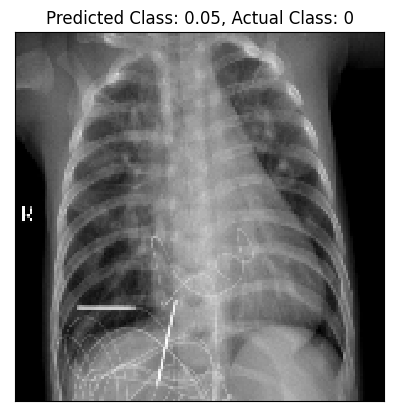

In [31]:
import matplotlib.pyplot as plt

def display_image(index):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[index].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class: {:.2f}, Actual Class: {}".format(float(predictions[index]), y_test[index]))
    plt.show()

# Assuming index is the desired index of the image you want to display
display_image(200)


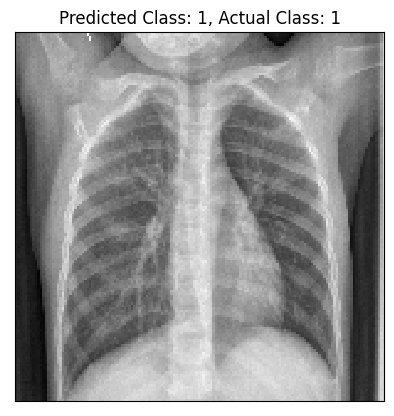

In [32]:
def display_image(index):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[index].reshape(150, 150), cmap="gray", interpolation='none')
    predicted_class = int(np.round(predictions[index]))
    plt.title("Predicted Class: {}, Actual Class: {}".format(predicted_class, y_test[index]))
    plt.show()

# Assuming index is the desired index of the image you want to display
display_image(410)

In [35]:
Bio_model.save("/Users/saivarunavadhuta/Desktop/kk_pro/models")